# sspa tutorial: Single sample pathway analysis in Python

### Installing and importing required packages
Please run all the cells in this section to ensure the following cells run smoothly

Install sspa

In [37]:
!pip install sspa

Import requried python packages

In [38]:
import sspa
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Install R packages GSVA and fGSEA via rpy2


In [39]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [40]:
%%R

if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("fgsea")
BiocManager::install("GSVA")

R[write to console]: 'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


R[write to console]: Bioconductor version 3.14 (BiocManager 1.30.16), R 4.1.2 (2021-11-01)

R[write to console]: Installing package(s) 'fgsea'

R[write to console]: trying URL 'https://bioconductor.org/packages/3.14/bioc/src/contrib/fgsea_1.20.0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 1274430 bytes (1.2 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to consol

## Load and process metabolomics data

Pre-processing example COVID mass spectrometry dataset

In [3]:
covid_data = sspa.load_example_data(omicstype="metabolomics", processed=False)

In [4]:
covid_values = covid_data.iloc[:, :-2]
data_filt = covid_values.loc[:, covid_values.isin([' ', np.nan, 0]).mean() < 0.5]

met_median = data_filt.median(axis=0, skipna=True)  # median value for each metabolite
scale_mat = data_filt.divide(met_median, axis=1)  # scale the matrix by the metabolite median
samp_median = scale_mat.median(axis=1, skipna=True)  # median value for each sample
norm_mat = data_filt.divide(samp_median, axis=0)  # scale by sample median

imputed_mat = norm_mat.fillna(norm_mat.median())
log2_mat = np.log2(imputed_mat)
processed_data = pd.DataFrame(StandardScaler().fit_transform(log2_mat), columns=imputed_mat.columns, index=imputed_mat.index)

In [5]:
processed_data.head()

,S-1-pyrroline-5-carboxylate,spermidine,1-methylnicotinamide,"12,13-DiHOME",alpha-ketoglutarate,kynurenate,3-hydroxyisobutyrate,3-hydroxy-3-methylglutarate,homovanillate (HVA),3-phosphoglycerate,...,"bilirubin degradation product, C16H18N2O5 (2)**","bilirubin degradation product, C17H18N2O4 (1)**","bilirubin degradation product, C17H18N2O4 (2)**","bilirubin degradation product, C17H18N2O4 (3)**","bilirubin degradation product, C17H20N2O5 (1)**","bilirubin degradation product, C17H20N2O5 (2)**",tetrahydrocortisol glucuronide,"N,N-dimethyl-pro-pro",oxindolylalanine,tetrahydrocortisone glucuronide (5)
sample_id,,,,,,,,,,,,,,,,,,,,,
1004596,-0.756979,0.552163,-0.317382,0.726321,-0.608606,-0.815994,-1.783925,-1.367964,-0.196991,-0.128764,...,-0.082822,-0.008485,0.073663,0.163788,-0.209951,-0.221960,0.143159,-0.830118,-0.846009,0.538409
1008097,0.079818,-0.839393,0.491280,-1.867786,-0.044496,-0.390190,-0.293450,-1.008025,-0.115982,-1.042743,...,0.025147,0.286299,0.114470,0.214872,-0.252672,-0.389336,0.299374,-0.278807,0.640936,0.931221
1008631,0.978372,-1.281277,-0.199487,0.355229,0.014784,-0.447509,-0.004413,1.236799,-0.516527,-1.008731,...,0.887881,0.120373,0.559326,0.579894,0.475454,0.392656,0.788248,-0.089581,0.633529,0.347035
1012545,-0.937540,-0.242391,1.636530,2.080704,-0.315610,0.111717,-0.148053,0.127448,-0.115982,-1.238096,...,1.080541,0.811562,0.682729,0.549101,0.416711,0.212145,-0.916428,-0.300312,1.123716,-0.077702
1022407,-0.652496,-0.110733,0.814461,-0.886903,0.409608,0.274345,0.774593,-0.497736,-0.115982,-1.023649,...,0.439088,0.970306,0.852974,0.835494,0.220687,0.197174,0.361032,-0.463056,0.196806,0.671461


OPTIONAL: Save the processed data to cvs format

processed_data.to_csv("example_covid_data_processed.csv")

Alternatively, to load the pre-processed dataset, set the argument "processed" to True

In [6]:
covid_data_processed = sspa.load_example_data(omicstype="metabolomics", processed=True)

### Loading your own dataset

The easiest way to load your own metabolomics dataset to use with sspa is to use the pandas.read_csv() function to read in the CSV file. You can also read in sample metadata as part of the same file, or as a separate file, as long as all metadata is in the form of pandas Series/DataFrame columns. 

In [7]:
# my_metabolomics_data = pd.read_csv("path/to/inputdata.csv")

## Identifier harmonisation

Use the identifier_conversion function to get identifier mappings. Change the input_type argument to the type of compound identifier you are converting from. This step may take a few minutes to complete.

In [8]:
compound_names = processed_data.columns.tolist()
conversion_table = sspa.identifier_conversion(input_type="name", compound_list=compound_names)

In [9]:
conversion_table

,Query,Match,HMDB,PubChem,ChEBI,KEGG,METLIN,SMILES,Comment
0,S-1-pyrroline-5-carboxylate,NA,NA,NA,NA,NA,NA,NA,0
1,spermidine,Spermidine,HMDB0001257,1102,16610,C00315,254,NCCCCNCCCN,1
2,1-methylnicotinamide,1-Methylnicotinamide,HMDB0000699,457,16797,C02918,5667,C[N+]1=CC=CC(=C1)C(N)=O,1
3,"12,13-DiHOME","12,13-DHOME",HMDB0004705,10236635,72665,C14829,None,CCCCCC(C(C/C=C\CCCCCCCC(=O)O)O)O,1
4,alpha-ketoglutarate,Oxoglutaric acid,HMDB0000208,51,30915,C00026,5218,OC(=O)CCC(=O)C(O)=O,1
...,...,...,...,...,...,...,...,...,...
895,"bilirubin degradation product, C17H20N2O5 (2)**",NA,NA,NA,NA,NA,NA,NA,0
896,tetrahydrocortisol glucuronide,NA,NA,NA,NA,NA,NA,NA,0
897,"N,N-dimethyl-pro-pro",NA,NA,NA,NA,NA,NA,NA,0
898,oxindolylalanine,NA,NA,NA,NA,NA,NA,NA,0


Count how many identifiers have matches

In [10]:
conversion_table["Comment"].value_counts()

0    547
1    353
Name: Comment, dtype: int64

In [11]:
processed_data_mapped = sspa.map_identifiers(conversion_table, output_id_type="ChEBI", matrix=processed_data)

In [12]:
processed_data_mapped

,16610,16797,72665,30915,18344,37373,16831,17050,16359,18101,...,64032,133677,133693,133694,28036,28238,76341,89312,17861,89188
sample_id,,,,,,,,,,,,,,,,,,,,,
1004596,0.552163,-0.317382,0.726321,-0.608606,-0.815994,-1.783925,-1.367964,-0.128764,-0.976062,-0.180645,...,0.698165,0.379316,0.293833,0.463559,-0.932831,-0.497137,-0.086215,-0.677852,-1.211516,0.544982
1008097,-0.839393,0.491280,-1.867786,-0.044496,-0.390190,-0.293450,-1.008025,-1.042743,1.087097,-0.142179,...,-0.001161,0.806867,0.694447,0.696535,0.166355,0.061275,-0.908010,-1.860243,-0.494520,0.296802
1008631,-1.281277,-0.199487,0.355229,0.014784,-0.447509,-0.004413,1.236799,-1.008731,-0.674438,-0.142179,...,-0.995114,0.673180,0.654255,0.987011,0.376914,0.581169,-1.309510,-0.057694,1.203206,-0.583187
1012545,-0.242391,1.636530,2.080704,-0.315610,0.111717,-0.148053,0.127448,-1.238096,-1.303566,-0.142179,...,0.291436,0.022498,0.161023,0.080969,-0.354917,1.503159,0.782149,-0.444072,0.061354,-0.141750
1022407,-0.110733,0.814461,-0.886903,0.409608,0.274345,0.774593,-0.497736,-1.023649,-0.602467,-0.142179,...,-0.001161,0.715905,0.447427,0.913464,-1.037644,-0.465360,-1.202589,-0.057694,-1.004384,0.062327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INCOV135-BL,0.107325,1.907765,-0.071532,0.416002,1.178623,0.930968,0.041873,0.404479,-0.224810,-0.142179,...,-0.533202,-0.180060,-0.324592,-0.235230,-0.168575,0.772554,-0.216535,-0.062482,1.355460,-1.286870
INCOV136-BL,1.449115,-0.192375,-0.071532,-0.469999,-0.988020,1.278558,0.510114,1.740470,1.195814,-0.595542,...,0.684258,-0.364671,-0.705684,-0.746311,-0.164621,-1.691772,0.529092,-0.295279,1.193723,-0.751587
INCOV137-BL,0.555251,0.411375,-0.071532,-1.964391,2.809565,0.797287,0.545391,0.663533,-1.557352,0.323058,...,-0.001161,-2.926096,-2.952633,-2.438364,1.981653,0.949535,0.567135,-0.197493,0.393815,-1.549920


## Importing pathways

Sspa comes with pre-loaded versions of Reactome (all supported organisms) release 78 (2022) and KEGG (human) release 98 (2022). It also allows users to easily download the latest version of KEGG and Reactome (all supported organisms). Users can also provide their own pathway files, as long as they are in GMT format. 

The sspa package has several functions for processing data for different databases. These are:
-	Process_reactome(organism, infile=None, download_latest=False, filepath=None)
-	Process_kegg(organism, infile=None, download_latest=False, filepath=None)
-	Process_gmt(infile) - load files in GMT format, ending in .gmt or .csv extension

For KEGG and Reactome, you will need to specify the organism code/name in the function call. KEGG 3-letter organism codes e.g. “hsa”, “mmu”, can be found at http://rest.kegg.jp/list/organism. Reactome organism names e.g. “Homo sapiens”, “Mus musculus”, can be found at https://reactome.org/content/schema/objects/Species. 


### Using pre-loaded pathway databases

Import the pre-loaded Reactome metabolic pathways (Release 78)

In [13]:
# We will import the metabolite pathways from the Reactome database
# We must specify one of the Reactome organism names
# This returns a GMT format pandas DataFrame containing the pathway information
reactome_pathways  = sspa.process_reactome(organism="Homo sapiens")

In [14]:
kegg_human_pathways  = sspa.process_kegg(organism="hsa")

In [15]:
reactome_pathways.head()

,Pathway_name,0,1,2,3,4,5,6,7,8,...,1468,1469,1470,1471,1472,1473,1474,1475,1476,1477
R-HSA-1059683,Interleukin-6 signaling,30616,456216,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
R-HSA-109581,Apoptosis,61120,4705,456216,28494,36080,15377,43474,30616,16412,...,None,None,None,None,None,None,None,None,None,None
R-HSA-109582,Hemostasis,15366,91144,15377,15378,15379,456215,456216,35366,37941,...,None,None,None,None,None,None,None,None,None,None
R-HSA-109606,Intrinsic Pathway for Apoptosis,456216,28494,36080,15377,43474,30616,None,None,None,...,None,None,None,None,None,None,None,None,None,None
R-HSA-109703,PKB-mediated events,456216,16618,17489,15377,456215,30616,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [16]:
kegg_human_pathways.head()

,Pathway_name,0,1,2,3,4,5,6,7,8,...,316,317,318,319,320,321,322,323,324,325
hsa00010,Glycolysis / Gluconeogenesis - Homo sapiens (h...,C00221,C15972,C01159,C00267,C06188,C06187,C00022,C01451,C00118,...,None,None,None,None,None,None,None,None,None,None
hsa00020,Citrate cycle (TCA cycle) - Homo sapiens (human),C15972,C00026,C00022,C05125,C00024,C16255,C00122,C00417,C00158,...,None,None,None,None,None,None,None,None,None,None
hsa00030,Pentose phosphate pathway - Homo sapiens (human),C03752,C00221,C01801,C00257,C00258,C20589,C00121,C00620,C00022,...,None,None,None,None,None,None,None,None,None,None
hsa00040,Pentose and glucuronate interconversions - Hom...,C20680,C06441,C00508,C04575,C00474,C00714,C00532,C05411,C00026,...,None,None,None,None,None,None,None,None,None,None
hsa00051,Fructose and mannose metabolism - Homo sapiens...,C01721,C00424,C00976,C00096,C00267,C00159,C01099,C11544,C01934,...,None,None,None,None,None,None,None,None,None,None


### Specifying your own pathways (in GMT format)

In [20]:
# download example GMT filt - Wikipathways Homo sapiens
import urllib.request

urllib.request.urlretrieve("https://wikipathways-data.wmcloud.org/current/gmt/wikipathways-20220310-gmt-Homo_sapiens.gmt",
                  "wikipathways-20220310-gmt-Homo_sapiens.gmt")

# load the GMT filt using sspa
custom_pathways = sspa.process_gmt("wikipathways-20220310-gmt-Homo_sapiens.gmt")

In [21]:
custom_pathways

,Pathway_name,2,3,4,5,6,7,8,9,10,...,439,440,441,442,443,444,445,446,447,448
Pathway_ID,,,,,,,,,,,,,,,,,,,,,
NIPBL role in DNA damage - Cornelia de Lange syndrome%WikiPathways_20220310%WP5119%Homo sapiens,http://www.wikipathways.org/instance/WP5119_r1...,9025,25836,9656,545,3014,11335,472,165918,None,...,None,None,None,None,None,None,None,None,None,None
Hair follicle development: cytodifferentiation - part 3 of 3%WikiPathways_20220310%WP2840%Homo sapiens,http://www.wikipathways.org/instance/WP2840_r1...,85293,6275,4254,404203,3880,4772,9622,8456,2353,...,None,None,None,None,None,None,None,None,None,None
Melanoma%WikiPathways_20220310%WP4685%Homo sapiens,http://www.wikipathways.org/instance/WP4685_r1...,4893,2353,1385,1021,1019,595,80243,673,4763,...,None,None,None,None,None,None,None,None,None,None
Pentose phosphate pathway in senescent cells%WikiPathways_20220310%WP5043%Homo sapiens,http://www.wikipathways.org/instance/WP5043_r1...,6120,221823,22934,7157,25796,6888,2539,7086,51071,...,None,None,None,None,None,None,None,None,None,None
Oxytocin signaling%WikiPathways_20220310%WP2889%Homo sapiens,http://www.wikipathways.org/instance/WP2889_r1...,5021,2776,5333,952,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Neural crest cell migration in cancer%WikiPathways_20220310%WP4565%Homo sapiens,http://www.wikipathways.org/instance/WP4565_r1...,5063,7204,6774,2353,57144,2151,2051,2050,6272,...,None,None,None,None,None,None,None,None,None,None
Pyrimidine metabolism and related diseases%WikiPathways_20220310%WP4225%Homo sapiens,http://www.wikipathways.org/instance/WP4225_r1...,6241,6240,7298,1373,1890,7084,7372,790,1723,...,None,None,None,None,None,None,None,None,None,None
SARS-CoV-2 B.1.1.7 variant antagonises innate immune activation%WikiPathways_20220310%WP5116%Homo sapiens,http://www.wikipathways.org/instance/WP5116_r1...,7187,9641,29110,7189,3456,3661,23586,9868,57506,...,None,None,None,None,None,None,None,None,None,None


### Downloading latest versions of KEGG and Reactome databases

Download latest KEGG pathways

In [ ]:
kegg_mouse_latest = sspa.process_kegg("mmu", download_latest=True, filepath=".")

Download latest Reactome pathways

In [ ]:
# download Reactome latest
reactome_mouse_latest = sspa.process_reactome("Mus musculus", download_latest=True, filepath=".")

Read in a .gmt file (here we use the latest Reactome pathways downloaded in the cell above)

In [ ]:
reactome_mouse_latest_read = sspa.process_gmt("./Reactome_Mus_musculus_pathways_compounds_R79.gmt")

In [ ]:
reactome_mouse_latest_read

## Conventional pathway analysis methods

### ORA

1. Identify the background set to be used. By default, sspa uses all the compounds annotated in the input metabolomics data (i.e. all the column identifiers) as the background set. Alternatively, the sspa_ora() function allows the user to specify a custom background set of compounds to be used. This must be passed to the function parameter ‘custom_bgset’ in the form of a python list. 
2. Perform differential abundance analysis and ORA using the sspa.over_representation_analysis() function. This function requires the processed metabolomics data (processed_data_mapped), a pandas Series containing the sample metadata (covid_data["Group"]), the cutoff threshold for differential abundance analysis, and an optional custom background set as arguments. Here we are using α= 0.05 to select differentially abundant metabolites, and all the metabolites in the processed abundance matrix as the background set (default). 


In [ ]:
ora_res = sspa.sspa_ora(processed_data_mapped, covid_data["Group"], reactome_pathways, 0.05, custom_bgset=None)

In [ ]:
ora_res.sort_values(by="P-value")

In [ ]:
top_20_pathways = ora_res.sort_values(by="P-value").iloc[0:20, :]
plt.figure(figsize=(8, 6))
sns.barplot(data=top_20_pathways, y="Pathway_name", x="P-value", orient="h", palette="magma")
plt.axvline(0.05, c="black")
# plt.savefig("ORA_top_20.png", dpi=300, bbox_inches="tight")
plt.show()

### GSEA
GSEA is a popular method for pathway analysis in the transcriptomics community (Subramanian et al., 2005). The sspa package has a wrapper function to allow users to use the R-based fast implementation of GSEA, fGSEA (Korotkevich, Sukhov and Sergushichev, 2019). The sspa function sspa_fgsea uses the signal-to-noise ratio as the metabolite ranking metric for GSEA. We encourage users to read about various ranking metrics available (Zyla et al., 2017) and experiment with the fGSEA package if they wish to use other ranking metrics. 

Run gsea using the sspa_fgsea() function. This function requires the processed metabolomics data, a pandas series containing the sample metadata, and the pathways DataFrame as input. The ranking metric used is the signal-to-noise ratio. 


In [41]:
gsea_res = sspa.sspa_fgsea(processed_data_mapped, covid_data['Group'], reactome_pathways)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [42]:
gsea_res.sort_values(by="P-value")

,ID,P-value,P-adjust,log2err,ES,NES,coverage,leadingEdge,Pathway_name
62,R-HSA-392499,0.004784,0.296717,0.407018,-0.775825,-1.731429,7,"[17596, 17012, 16610, 4208, 16335]",Metabolism of proteins
86,R-HSA-5619063,0.012696,0.296717,0.380730,-0.826367,-1.507984,4,"[17596, 16708, 17562, 16335]",Defective SLC29A3 causes histiocytosis-lymphad...
116,R-HSA-74217,0.012696,0.296717,0.380730,-0.826367,-1.507984,4,"[17596, 16708, 17368, 16335]",Purine salvage
69,R-HSA-425397,0.013132,0.296717,0.380730,-0.637012,-1.622520,12,"[17596, 16708, 16525, 28865, 17368, 17562, 16335]","Transport of vitamins, nucleosides, and relate..."
94,R-HSA-597592,0.015571,0.296717,0.380730,-0.761820,-1.501840,5,"[17012, 16610, 4208]",Post-translational protein modification
...,...,...,...,...,...,...,...,...,...
47,R-HSA-211945,0.946565,0.955812,0.079556,0.223825,0.616344,8,"[25858, 31697, 28834, 15724, 27732]",Phase I - Functionalization of compounds
45,R-HSA-211859,0.949005,0.955812,0.025482,-0.209427,-0.600773,19,"[32635, 16610, 16335, 4047]",Biological oxidations
85,R-HSA-561048,0.949398,0.955812,0.056648,0.357827,0.574729,2,"[17775, 422]",Organic anion transport
55,R-HSA-3296197,0.949398,0.955812,0.056648,0.357827,0.574729,2,"[37098, 422]",Hydroxycarboxylic acid-binding receptors


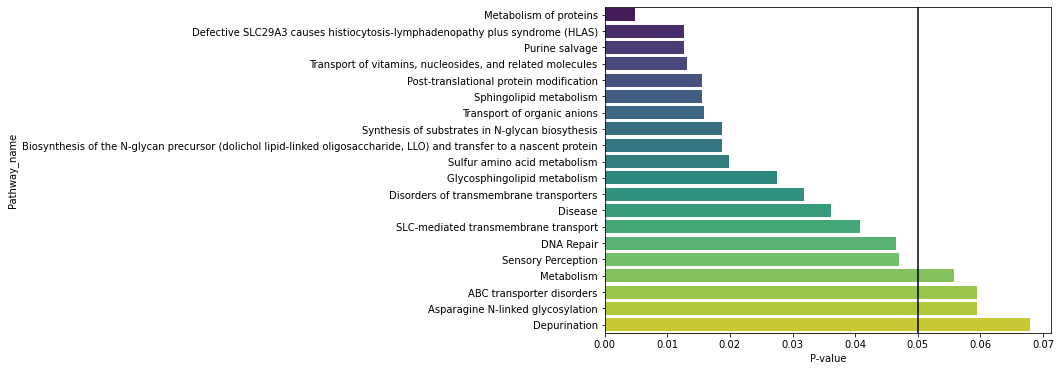

In [43]:
top_20_pathways_gsea = gsea_res.sort_values(by="P-value").iloc[0:20, :]
plt.figure(figsize=(8, 6))
sns.barplot(data=top_20_pathways_gsea, y="Pathway_name", x="P-value", orient="h", palette="viridis")
plt.axvline(0.05, c="black")
# plt.savefig("GSEA_top_20.png", dpi=300, bbox_inches="tight")
plt.show()

## Single-sample pathway analysis methods

Using kPCA method

In [ ]:
kpca_scores = sspa.sspa_kpca(processed_data_mapped, reactome_pathways)

In [ ]:
# Inspect the pathway score matrix
kpca_scores

### Visualise single-sample pathway analysis results

In [ ]:
# Pathway-based PCA plot

# Perfom two component PCA using sklearn
pca = PCA(n_components=2).fit_transform(kpca_scores)

# Plot the first two components as a scatterplot
plt.style.use("default")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
sns.scatterplot(x=pca[:, 0 ], y=pca[:, 1], hue=example_data["Group"], ax=ax1, s=100, alpha=0.5)
sns.scatterplot(x=pca[:, 0 ], y=pca[:, 1], hue=example_data["WHO_status"], ax=ax2, s=100, alpha=0.5)

# Set axis labels 
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")

plt.tight_layout()
# plt.savefig(".kpca_pca_plots.png", dpi=350, bbox_inches="tight")

plt.show()

In [ ]:
# Plot a heatmap using the pathway scores
g = sns.clustermap(kpca_scores.T,
               cmap="RdBu_r",
               z_score=1,
              col_colors = ["tab:red" if i == "COVID19 " else "tab:green" for i in example_data["Group"]],
              xticklabels=False,
              yticklabels=False)
g.ax_heatmap.set_xlabel("Samples")
g.ax_heatmap.set_ylabel("Pathways")

# plt.savefig("kpca_heatmap.png", dpi=350, bbox_inches="tight")
plt.show()

In [ ]:
# Plot pathway scores from two pathways against each other
plt.style.use("default")
fig, ax1 = plt.subplots(1, 1, figsize=(6, 6), sharex=True, sharey=True)
sns.scatterplot(x=kpca_scores.loc[:, "R-HSA-109582"], y=kpca_scores.loc[:, "R-HSA-112314"], hue=example_data["Group"], ax=ax1, s=100, alpha=0.5)
ax1.se


### Additional sspa methods

Using ssClustPA method

In [24]:
ssclustpa_res = sspa.sspa_cluster(processed_data_mapped, reactome_pathways)

In [25]:
ssclustpa_res.head()

,R-HSA-109582,R-HSA-110331,R-HSA-112310,R-HSA-112311,R-HSA-112315,R-HSA-112316,R-HSA-140179,R-HSA-1428517,R-HSA-1430728,R-HSA-1483115,...,R-HSA-9614085,R-HSA-964975,R-HSA-9658195,R-HSA-9660821,R-HSA-9662851,R-HSA-9664433,R-HSA-9709957,R-HSA-9717189,R-HSA-9717207,R-HSA-975576
sample_id,,,,,,,,,,,,,,,,,,,,,
1004596,0.842546,2.149807,3.004040,1.137139,1.245667,1.245667,1.080146,0.275888,9.290176,0.685532,...,1.186166,1.236661,1.662942,1.662942,2.921099,1.662942,0.662225,0.604675,1.464784,3.108626
1008097,1.146962,1.247930,3.614950,1.795596,1.965219,1.965219,2.649599,1.352439,9.480155,0.524092,...,1.382637,0.416886,1.794335,1.794335,2.192993,1.794335,0.999798,0.905723,0.950770,3.001683
1008631,1.243143,2.372639,2.778547,0.382086,0.757608,0.757608,2.241990,0.687339,8.649795,1.749066,...,0.949074,0.887795,1.139879,1.139879,1.453090,1.139879,1.175009,0.996605,1.435556,1.892696
1012545,1.538546,2.522454,2.224010,0.815295,1.670214,1.670214,1.127789,1.405412,9.397839,0.613195,...,1.085702,0.693042,1.446076,1.446076,2.528114,1.446076,1.336232,1.055157,0.557411,2.398027
1022407,0.736828,1.385961,2.096943,0.809898,0.904912,0.904912,1.458528,1.206239,9.706424,3.960846,...,0.413243,0.430117,0.714917,0.714917,1.775351,0.714917,2.076571,0.510637,0.844478,1.142661


Using ssClustPA(proj) method

In [26]:
ssclustpa_proj_res = sspa.sspa_cluster(processed_data_mapped, reactome_pathways, projection=True)
ssclustpa_proj_res.head()

,R-HSA-109582,R-HSA-110331,R-HSA-112310,R-HSA-112311,R-HSA-112315,R-HSA-112316,R-HSA-140179,R-HSA-1428517,R-HSA-1430728,R-HSA-1483115,...,R-HSA-9614085,R-HSA-964975,R-HSA-9658195,R-HSA-9660821,R-HSA-9662851,R-HSA-9664433,R-HSA-9709957,R-HSA-9717189,R-HSA-9717207,R-HSA-975576
sample_id,,,,,,,,,,,,,,,,,,,,,
1004596,0.432431,-0.809846,1.259796,-0.465116,-1.268354,1.268354,-0.234893,0.710179,3.725958,1.081345,...,-1.238117,1.437795,-1.397047,1.397047,-1.388473,-1.397047,0.122498,0.168715,-0.597665,1.732649
1008097,0.670622,-0.168902,1.669575,0.527829,-1.663985,1.663985,1.466172,0.475442,4.139843,1.048405,...,-2.065633,0.508488,-0.273640,0.273640,-0.283702,-0.273640,1.191507,0.978796,0.388632,1.504902
1008631,0.216090,-1.466260,1.230770,-0.424762,-1.223171,1.223171,0.891863,0.310017,2.566553,1.219420,...,-0.558032,-0.620324,-0.064592,0.064592,-0.063807,-0.064592,-0.329027,-0.459150,-0.435082,0.371408
1012545,0.315463,-0.409648,0.116479,-1.128706,-0.112159,0.112159,-0.198206,1.426288,3.838005,1.004299,...,-0.469632,-0.431370,-1.002519,1.002519,-0.995167,-1.002519,0.548208,0.188398,0.921737,0.989025
1022407,1.194030,-0.471063,0.442861,-0.073863,-0.438619,0.438619,0.298758,0.176721,2.155829,2.051870,...,-0.920009,0.679831,-0.556298,0.556298,-0.553644,-0.556298,0.159914,0.661327,0.079213,-0.229281


Using z-score method

In [27]:
zscore_res = sspa.sspa_zscore(processed_data_mapped, reactome_pathways)

In [28]:
zscore_res.head()

,R-HSA-109582,R-HSA-110331,R-HSA-112310,R-HSA-112311,R-HSA-112315,R-HSA-112316,R-HSA-140179,R-HSA-1428517,R-HSA-1430728,R-HSA-1483115,...,R-HSA-9614085,R-HSA-964975,R-HSA-9658195,R-HSA-9660821,R-HSA-9662851,R-HSA-9664433,R-HSA-9709957,R-HSA-9717189,R-HSA-9717207,R-HSA-975576
sample_id,,,,,,,,,,,,,,,,,,,,,
1004596,0.457090,-0.711271,-1.397748,-1.046176,-1.397748,-1.397748,0.187717,-0.609464,-3.434376,-0.781320,...,-0.787468,-1.415639,-0.603738,-0.603738,-0.603738,-0.603738,-0.026597,-0.117513,-0.160936,-1.738374
1008097,-0.993119,-0.120412,-1.844493,-1.515670,-1.844493,-1.844493,-1.495914,-0.000446,-1.738864,-1.083332,...,-2.051787,-0.525661,-0.429673,-0.429673,-0.429673,-0.429673,1.326981,1.154814,0.901360,-1.538635
1008631,0.910881,-1.444900,-0.950140,-0.294227,-0.950140,-0.950140,-0.814119,-0.361688,-1.132265,-1.781481,...,-0.196933,0.613048,-0.211095,-0.211095,-0.211095,-0.211095,-0.290137,-0.689715,-0.709069,-0.341391
1012545,1.441909,-0.567366,0.168596,-0.367191,0.168596,0.168596,0.246480,-1.432125,-0.082758,-0.722931,...,-0.808399,0.427765,-0.937451,-0.937451,-0.937451,-0.937451,1.051095,0.664667,0.811050,-1.005567
1022407,0.460137,-0.487182,-0.410256,-0.647859,-0.410256,-0.410256,-0.312318,0.002792,-1.186402,-3.373450,...,-0.735371,-0.683723,-0.235746,-0.235746,-0.235746,-0.235746,-0.391630,0.658368,0.314006,0.227265


Using SVD (PLAGE) method

In [29]:
svd_res = sspa.sspa_svd(processed_data_mapped, reactome_pathways)
svd_res.head()

,R-HSA-109582,R-HSA-110331,R-HSA-112310,R-HSA-112311,R-HSA-112315,R-HSA-112316,R-HSA-140179,R-HSA-1428517,R-HSA-1430728,R-HSA-1483115,...,R-HSA-9614085,R-HSA-964975,R-HSA-9658195,R-HSA-9660821,R-HSA-9662851,R-HSA-9664433,R-HSA-9709957,R-HSA-9717189,R-HSA-9717207,R-HSA-975576
sample_id,,,,,,,,,,,,,,,,,,,,,
1004596,0.025154,0.038171,-0.048890,-0.038417,-0.048890,-0.048890,-0.009910,0.029593,0.066320,0.047038,...,0.047223,0.066037,0.047333,0.047333,0.047333,0.047333,-0.015102,-0.015411,-0.034028,0.090833
1008097,0.040495,0.006462,-0.072214,0.017332,-0.072214,-0.072214,0.078974,0.019038,0.070181,0.065221,...,0.123042,0.024521,0.011472,0.011472,0.011472,0.011472,-0.051686,-0.044387,0.006935,0.080396
1008631,0.012276,0.077541,-0.057978,-0.028659,-0.057978,-0.057978,0.042980,0.012810,0.039579,0.107252,...,0.011810,-0.028597,0.013049,0.013049,0.013049,0.013049,0.011780,0.016398,-0.013485,0.017838
1012545,0.016090,0.030448,-0.008567,-0.072126,-0.008567,-0.008567,-0.013012,0.060650,0.068101,0.043523,...,0.048478,-0.019954,0.058266,0.058266,0.058266,0.058266,-0.007852,0.003426,0.041747,0.052543
1022407,0.065893,0.026145,-0.020706,-0.010782,-0.020706,-0.020706,0.016488,0.008432,0.031450,0.203094,...,0.044099,0.031894,0.019446,0.019446,0.019446,0.019446,-0.016561,-0.033974,-0.001071,-0.011875


Using GSVA (Hanzelmann et al)

In [30]:
gsva_res = sspa.sspa_gsva(processed_data_mapped, reactome_pathways)
gsva_res.head()

Estimating GSVA scores for 149 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%



,R-HSA-109582,R-HSA-110331,R-HSA-112310,R-HSA-112311,R-HSA-112315,R-HSA-112316,R-HSA-140179,R-HSA-1428517,R-HSA-1430728,R-HSA-1483115,...,R-HSA-9614085,R-HSA-964975,R-HSA-9658195,R-HSA-9660821,R-HSA-9662851,R-HSA-9664433,R-HSA-9709957,R-HSA-9717189,R-HSA-9717207,R-HSA-975576
1004596,0.554568,-0.306454,-0.442471,-0.637277,-0.442471,-0.442471,0.460965,-0.012862,-0.235190,-0.523030,...,-0.142564,-0.709265,-0.018411,-0.018411,-0.018411,-0.018411,0.070740,0.070513,0.070288,-0.859425
1008097,-0.490385,0.051118,-0.604516,-0.731629,-0.604516,-0.604516,-0.712460,0.307441,-0.021119,-0.638978,...,-0.910543,-0.170811,0.104386,0.104386,0.104386,0.104386,0.723473,0.685897,0.667732,-0.755865
1008631,0.505834,-0.769968,-0.472574,-0.142831,-0.472574,-0.472574,-0.747204,0.012862,0.007271,-0.705825,...,0.068416,0.690096,0.067524,0.067524,0.067524,0.067524,-0.089609,-0.378205,-0.539936,-0.192985
1012545,0.592949,-0.249120,-0.073379,-0.523363,-0.073379,-0.073379,0.057508,-0.626722,-0.044590,-0.854219,...,-0.827051,0.511182,-0.558809,-0.558809,-0.558809,-0.558809,0.582653,0.382609,0.484814,-0.584665
1022407,0.645511,-0.240636,0.055016,-0.351438,0.055016,0.055016,-0.306294,0.319806,0.163049,-0.716866,...,-0.463667,-0.329073,0.167203,0.167203,0.167203,0.167203,0.007871,0.576923,0.440895,0.514377
